In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%config InlineBackend.figure_format = 'retina'

import torch 
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import MNIST
from torchvision import transforms
from PIL import Image

import torch.optim as optim
import healpy as hp

# CNN for HEALPix data structure

This notebook served the same purpose as a PyTorch version of HEALPix CNN. We should keep in mind that this implementation of CNN on spheres is relatively naive, and there are some other sophisticated models in the field of geometric deep learning. However, what I would like to show is a quick and dirty way for astronomers to try CNN on spheres with their own hand and laptop. The other point is that the hierarchical pixelization scheme might be helpful for future CNN on spheres. HEALPix by its nature is not fully hierarchically arranged because of the 12 base pixels.

# Download Your Data

In [2]:
transet = MNIST(root='./mnist', train=True, download=True)

# Data Transformer

Dataloader in PyTorch allows us to avoid loading everything into memory during the training process. We just designed a custom transformation class to allow us to load rectangle PIL images into HEALPix data structure.

In [3]:
class HEALPixTransform(object):
    '''convert a square PIL img to a HEALPix array in numpy'''
    def __init__(self, nside):
        self.nside = nside 

    def __call__(self, img):
        if isinstance(img, np.ndarray):
            return self.img2healpix(img, self.nside)
        else:
            return self.img2healpix(np.array(img), self.nside)
        
    def cart_healpix(self, cartview, nside):
        '''read in an matrix and return a healpix pixelization map'''
        # Generate a flat Healpix map and angular to pixels
        healpix  = np.zeros(hp.nside2npix(nside), dtype=np.double)
        hptheta  = np.linspace(0, np.pi, num=cartview.shape[0])[:, None]
        hpphi    = np.linspace(-np.pi, np.pi, num=cartview.shape[1])
        pix = hp.ang2pix(nside, hptheta, hpphi)

        # re-pixelize
        healpix[pix] = np.fliplr(cartview)
        return healpix
    
    def ring2nest(self, healpix):
        nest = np.zeros(healpix.shape)
        ipix = hp.ring2nest(nside=hp.npix2nside(nest.shape[-1]), 
                            ipix=np.arange(nest.shape[-1]))
        nest[ipix] = healpix
        return nest
    
    def img2healpix(self, digit, nside):
        '''
        padding squre digits to 1*2 rectangles and
        convert them to healpix with a given nside
        '''
        h, w = digit.shape
        img = np.zeros((h, 2 * h))
        img[:, h - w // 2 : h - w // 2 + w] = digit
        return self.ring2nest(self.cart_healpix(img, nside))

class ToTensor(object):
    '''convert ndarrays to Tensors'''
    
    def __call__(self, healpix):
        return torch.from_numpy(healpix).double()

class Normalize(object):
    
    def __init__(self, mean, std):
        self.mean = mean
        self.std  = std
        
    def __call__(self, tensor):
        tensor.div_(255)#.sub_(self.mean
#            ).div_(self.std).clamp_(min=0., max=1.
#            )
        return tensor.unsqueeze(0)

You can test the functionality of HEALPix transformation class using you own image.  

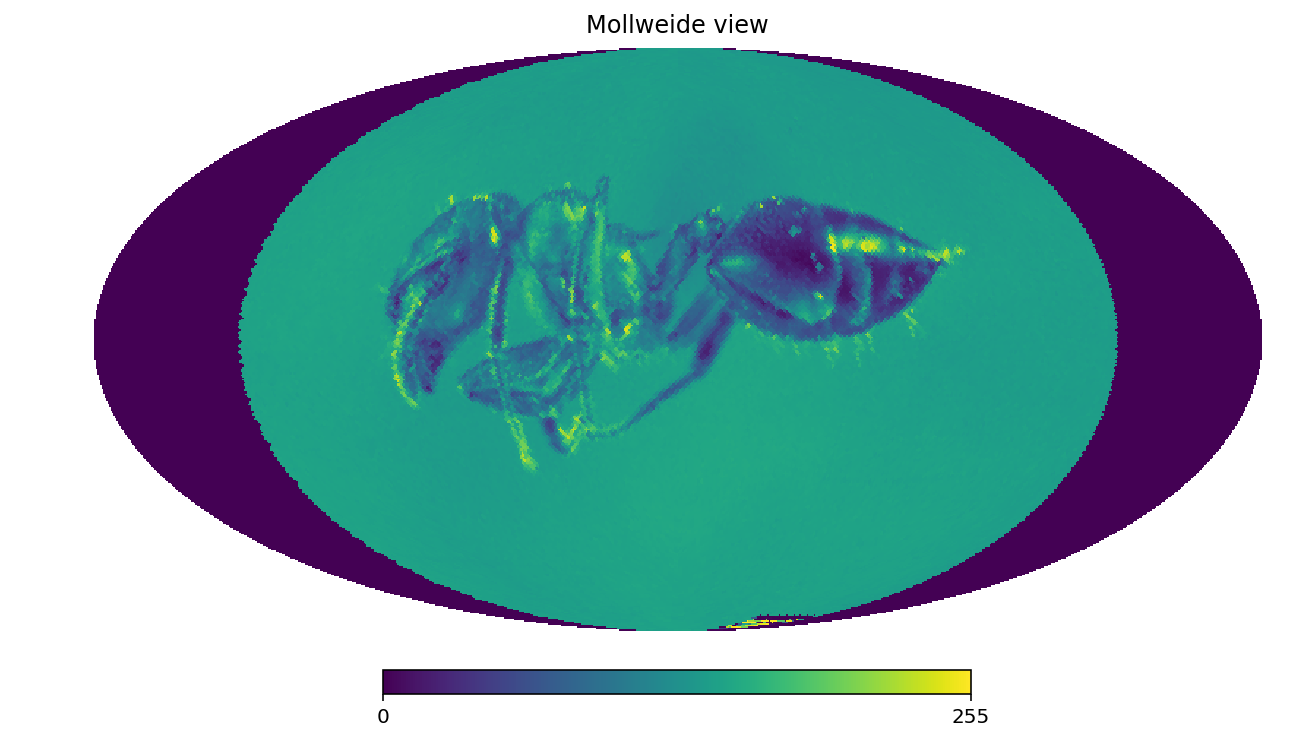

In [4]:
img = Image.open("hymenoptera_data/train/ants/0013035.jpg").convert('L') # please load your own image or skip this cell
hT = HEALPixTransform(nside=64)
hp.mollview(hT(img), nest=1)

# 1-D Conv Net

Since HEALPix data structure grouped with each 4 elements, 1D Conv with kernel_size = 4 and stride = 4 would be elgible to apply on HEALPix.


In [5]:
class HEALPixNet(nn.Module):
    
    def __init__(self):
        super(HEALPixNet, self).__init__()
        # nside = 8 -> nside = 4
        self.conv1 = nn.Conv1d(1,  32, 4, stride=4)
        
        # nside = 4 -> nside = 2
        self.conv2 = nn.Conv1d(32, 64, 4, stride=4)
        
        # nside**2 * 12 = 48
        self.fc1   = nn.Linear(48 * 64, 128)
        self.fc2   = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 48 * 64)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [6]:
net = HEALPixNet()
net = net.double()
net

HEALPixNet(
  (conv1): Conv1d(1, 32, kernel_size=(4,), stride=(4,))
  (conv2): Conv1d(32, 64, kernel_size=(4,), stride=(4,))
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

# Data Pre-Processing

In [7]:
batch_size = 32

data_transforms = {
    'train' : transforms.Compose([
#        transforms.RandomHorizontalFlip(),
        HEALPixTransform(nside=8),
        ToTensor(),
        Normalize(0.083, 0.254) # mnist setting
    ]),
    'val'   : transforms.Compose([
        HEALPixTransform(nside=8),
        ToTensor(),
        Normalize(0.083, 0.254) # mnist setting
    ]),
}

data_loaders = {
    'train' : torch.utils.data.DataLoader(
        MNIST(root='./mnist', train=True, download=True, 
              transform=data_transforms['train']),
        batch_size=batch_size, shuffle=True,
    ),
    'val'   : torch.utils.data.DataLoader(
        MNIST(root='./mnist', train=False,
              transform=data_transforms['val']),
        batch_size=batch_size, shuffle=True,
    ),
}

# Visualize Some Samples

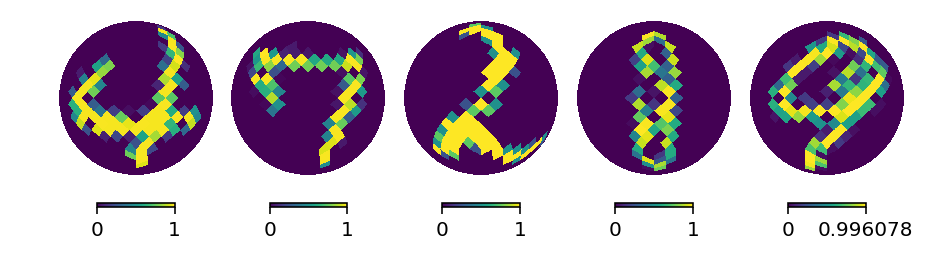

In [8]:
inputs, classes = next(iter(data_loaders['train']))

for i in range(5):
    hp.orthview(inputs[i].numpy()[0, :], nest=True, sub=(1, 5, i + 1), half_sky=1, title='')

# Optimizer

In [9]:
from torch.optim import lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training Process

In [10]:
import copy
import time

In [109]:
t = time.time()

best_wts = copy.deepcopy(net.state_dict())
best_acc = 0.0
num_epochs = 100
use_gpu    = False

history = {'train_loss' : [], 
           'val_loss'   : [],
           'train_acc'  : [],
           'val_acc'    : []}

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('=' * 10)
    
    for phase in ['train', 'val']:
        running_loss     = 0.
        running_corrects = 0
        
        if phase == 'train':
            scheduler.step()
            net.train(True)
        else:
            net.train(False)
        
        for data in data_loaders[phase]:
            inputs, labels = data
            
            if use_gpu:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:
                inputs = Variable(inputs)
                labels = Variable(labels)
            
            optimizer.zero_grad()
            
            outputs  = net(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss     = criterion(outputs, labels)
            
            if phase == 'train':
                loss.backward()
                optimizer.step()
                
            running_loss += loss.data.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_loss = running_loss / len(data_loaders[phase].dataset)
        epoch_acc  = running_corrects.float() / len(data_loaders[phase].dataset)
        
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_wts = copy.deepcopy(net.state_dict())
            
        # saving history
        history['{}_loss'.format(phase)].append(epoch_loss)
        history['{}_acc'.format(phase)].append(epoch_acc)        
            
    print()    

time_elapsed = time.time() - t 
print('Complete in {:.0f}min {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Top Accuracy: {:4f}'.format(best_acc))

net.load_state_dict(best_wts)

Epoch 0/99
train Loss: 1.6607 Acc: 0.8063
val Loss: 1.5394 Acc: 0.9233

Epoch 1/99
train Loss: 1.5765 Acc: 0.8863
val Loss: 1.5228 Acc: 0.9385

Epoch 2/99
train Loss: 1.5603 Acc: 0.9016
val Loss: 1.5150 Acc: 0.9462

Epoch 3/99
train Loss: 1.5490 Acc: 0.9126
val Loss: 1.5086 Acc: 0.9527

Epoch 4/99
train Loss: 1.5429 Acc: 0.9191
val Loss: 1.5055 Acc: 0.9556

Epoch 5/99
train Loss: 1.5347 Acc: 0.9265
val Loss: 1.5019 Acc: 0.9595

Epoch 6/99
train Loss: 1.5304 Acc: 0.9311
val Loss: 1.4999 Acc: 0.9610

Epoch 7/99
train Loss: 1.5270 Acc: 0.9346
val Loss: 1.4965 Acc: 0.9650

Epoch 8/99
train Loss: 1.5217 Acc: 0.9402
val Loss: 1.4968 Acc: 0.9645

Epoch 9/99
train Loss: 1.5208 Acc: 0.9404
val Loss: 1.4949 Acc: 0.9657

Epoch 10/99
train Loss: 1.5125 Acc: 0.9492
val Loss: 1.4908 Acc: 0.9700

Epoch 11/99
train Loss: 1.5093 Acc: 0.9519
val Loss: 1.4903 Acc: 0.9706

Epoch 12/99
train Loss: 1.5072 Acc: 0.9541
val Loss: 1.4898 Acc: 0.9715

Epoch 13/99
train Loss: 1.5069 Acc: 0.9546
val Loss: 1.4900 A

train Loss: 1.5004 Acc: 0.9617
val Loss: 1.4878 Acc: 0.9733

Epoch 99/99
train Loss: 1.5013 Acc: 0.9602
val Loss: 1.4878 Acc: 0.9733

Complete in 115min 56s
Top Accuracy: 0.973300


Since I put a dropout layer during training, the training loss was higher than validation loss.

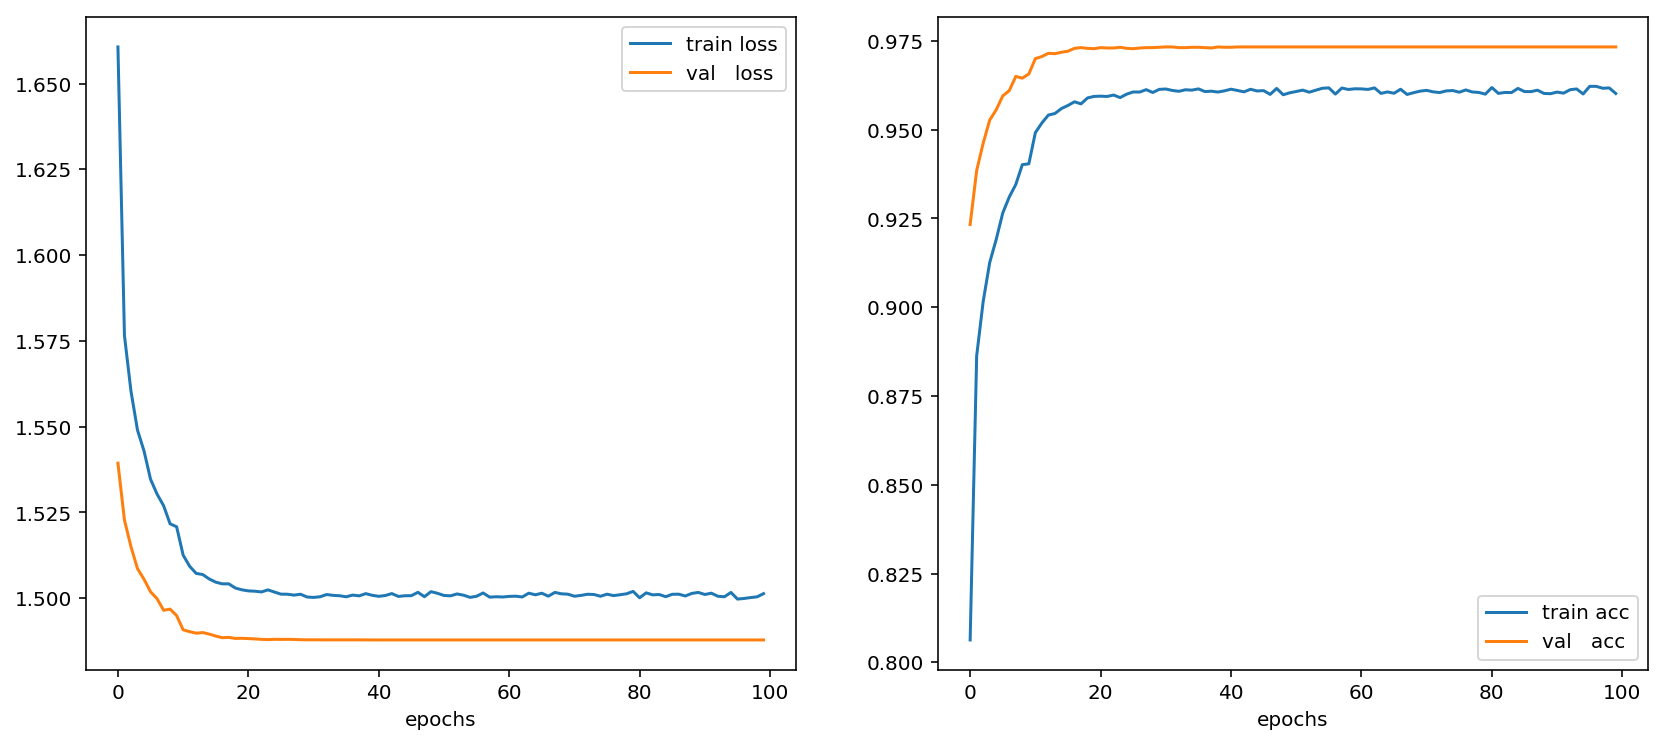

In [124]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(history['train_loss'], label='train loss')
ax[0].plot(history['val_loss'],   label='val   loss')
ax[0].set_xlabel('epochs')
ax[1].plot(history['train_acc'], label='train acc')
ax[1].plot(history['val_acc'],   label='val   acc')
ax[1].set_xlabel('epochs')
ax[0].legend()
ax[1].legend();